In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import bambi as bmb 
import hssm

import os
import arviz as az 
import pymc as pm 
from utils import *
hssm.set_floatX("float64")
random_seed = 10
import hssm.plotting


Setting PyTensor floatX type to float64.
Setting "jax_enable_x64" to True. If this is not intended, please set `jax` to False.


In [5]:
files = os.listdir('data/')
comb_data = pd.concat([extract_data(fname) for fname in files]).reset_index(drop=True)
comb_data = comb_data.loc[comb_data['rt'] < 10].reset_index(drop = True)
comb_data = comb_data.loc[comb_data['rt'] > 0.1].reset_index(drop = True)

comb_data['bumps_'] = '0_noisy'
comb_data.loc[comb_data['bumps'] == 'single', 'bumps_'] = '1_single'
comb_data.loc[comb_data['bumps'] == 'center', 'bumps_'] = '1_center'
comb_data['participant_id'] = comb_data['participant']

In [6]:
# model_default = hssm.HSSM(data=comb_data[['participant', 'rt', 'response']])
# model_default.graph()

In [20]:
# Model v
hssm_model_v = hssm.HSSM(data=comb_data[['participant_id', 'rt', 'response', 'means', 'direction', 'bumps_', 'diff_dir', 'difference', 'cond']], 
            include=
            [
              {"name": "v",
              "formula": "v ~ C(direction) + C(diff_dir) + C(cond) + C(bumps_) + difference"
              }
              ],
              hierarchical = False,
              p_outlier = 0.05,
              lapse=bmb.Prior("Uniform", lower=0.0, upper=20.0),
              loglik_kind = "approx_differentiable",
              prior_settings="safe"
              )

# Model a
hssm_model_a = hssm.HSSM(data=comb_data[['participant_id', 'rt', 'response', 'means', 'direction', 'bumps_', 'diff_dir', 'difference', 'cond']], 
            include=
            [
              {"name": "a",
              "formula": "a ~ C(direction) + C(diff_dir) + C(cond) + C(bumps_) + difference"
              }
              ],
              hierarchical = False,
              p_outlier = 0.05,
              lapse=bmb.Prior("Uniform", lower=0.0, upper=20.0),
              loglik_kind = "approx_differentiable",
              prior_settings="safe"
              )

# Model z
hssm_model_z = hssm.HSSM(data=comb_data[['participant_id', 'rt', 'response', 'means', 'direction', 'bumps_', 'diff_dir', 'difference', 'cond']], 
            include=
            [
              {"name": "z",
              "formula": "z ~ C(direction) + C(diff_dir) + C(cond) + C(bumps_) + difference"
              }
              ],
              hierarchical = False,
              p_outlier = 0.05,
              lapse=bmb.Prior("Uniform", lower=0.0, upper=20.0),
              loglik_kind = "approx_differentiable",
              prior_settings="safe"
              )

# Model va
hssm_model_va = hssm.HSSM(data=comb_data[['participant_id', 'rt', 'response', 'means', 'direction', 'bumps_', 'diff_dir', 'difference', 'cond']], 
            include=
            [
              {"name": "v",
              "formula": "v ~ C(direction) + C(diff_dir) + C(cond) + C(bumps_) + difference"
              },
              {"name": "a",
              "formula": "a ~ C(direction) + C(diff_dir) + C(cond) + C(bumps_) + difference"
              }
          
              ],
              hierarchical = False,
              p_outlier = 0.05,
              lapse=bmb.Prior("Uniform", lower=0.0, upper=20.0),
              loglik_kind = "approx_differentiable",
              prior_settings="safe"
              )





In [21]:
# hssm_model.graph()

In [22]:
# sample = hssm_model.sample()

# Load and Plot Model

In [23]:
files = os.listdir('modeling_results/hssm_results/')
models = {f: az.from_netcdf(f'modeling_results/hssm_results/{f}') for f in files}

In [24]:
hssm_model_a._inference_obj = models['model_a']
hssm_model_v._inference_obj = models['model_v']
hssm_model_z._inference_obj = models['model_z']
hssm_model_va._inference_obj = models['model_va']


In [25]:
# az.compare(models)

In [27]:
hssm_model_va.summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v_C(direction)[1.0],0.024,0.338,-0.407,0.541,0.168,0.129,5.0,12.0,2.92
v_C(diff_dir)[1.0],-0.365,0.361,-0.829,0.061,0.179,0.138,5.0,26.0,2.11
v_C(cond)[numerical],0.228,0.517,-0.304,0.909,0.257,0.197,5.0,12.0,2.85
v_C(cond)[slider],-0.221,0.190,-0.396,0.094,0.094,0.072,5.0,14.0,2.78
v_C(bumps_)[1_single],-0.209,0.451,-0.985,0.131,0.225,0.172,5.0,23.0,2.55
v_C(bumps_)[2_center],0.081,0.204,-0.273,0.236,0.101,0.077,6.0,11.0,2.67
v_difference,0.009,0.014,-0.008,0.025,0.007,0.005,5.0,12.0,2.21
a_C(direction)[1.0],-0.305,0.308,-0.641,0.014,0.153,0.118,5.0,11.0,2.27
a_C(diff_dir)[1.0],-0.139,0.185,-0.413,0.064,0.092,0.071,5.0,16.0,2.62
a_C(cond)[numerical],-0.212,0.536,-0.984,0.541,0.267,0.204,5.0,11.0,3.03


In [13]:
# comp_models = {'model_1':models['model_1'], 
#                'model_3':models['model_3'],
#                'model_4':models['model_4'],
#                'model_6':models['model_6']
#                }

# az.compare(comp_models)

In [18]:
# hssm_model_a.plot_trace()

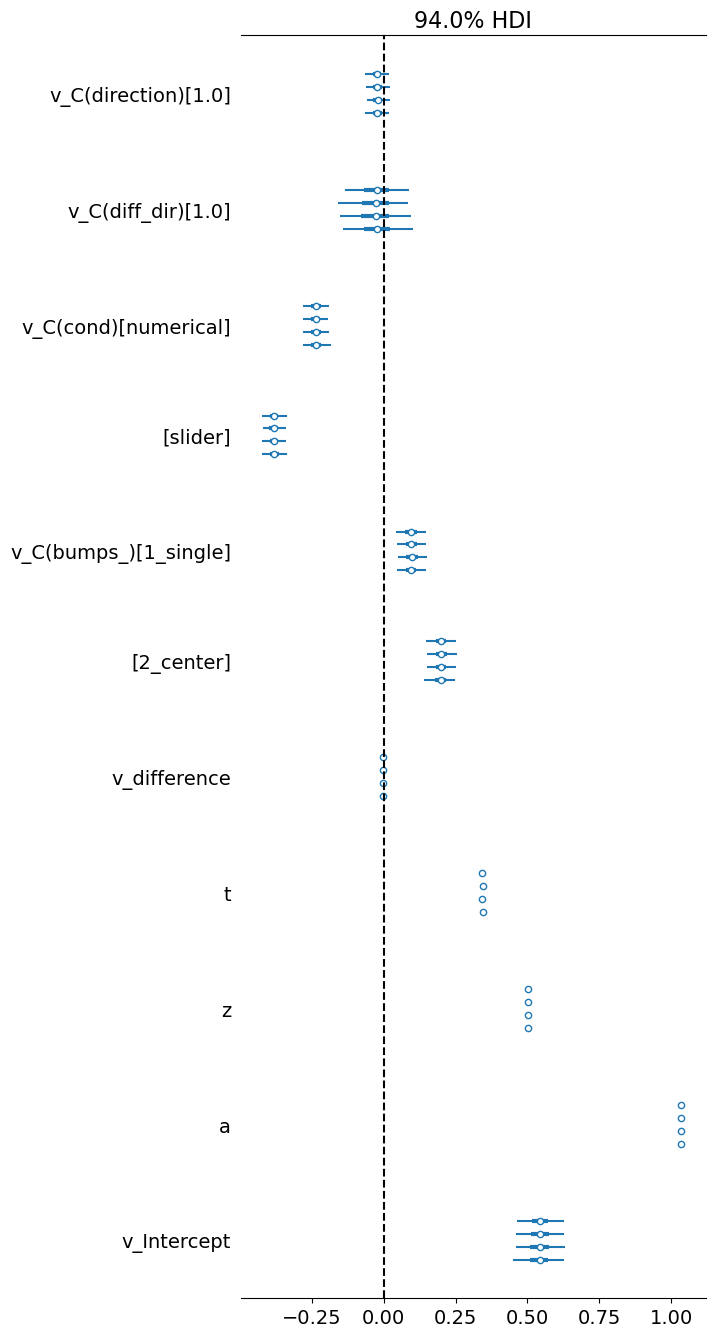

In [17]:
az.plot_forest(models['model_6'])
plt.axvline(0, ls = '--', color ='black')

In [18]:
# az.plot_forest(hssm_model_4.traces, var_names=['cond', 'bumps','diff', 'direction'], filter_vars='regex')
# plt.axvline(0, ls = '--', color = 'black')

# Using pymc

In [3]:
import pytensor
from hssm.distribution_utils import (
    make_distribution,  # A general function for making Distribution classes
    make_distribution_from_onnx,  # Makes Distribution classes from onnx files
    make_distribution_from_blackbox,  # Makes Distribution classes from callables
)

# pm.Distributions that represents the top-level distribution for
# DDM models (the Wiener First-Passage Time distribution)
from hssm.likelihoods import logp_ddm_sdv, DDM
from hssm.utils import download_hf
pytensor.config.floatX = "float32"


In [4]:
comb_data[['response', 'rt']].values

array([[-1.        ,  3.88154778],
       [-1.        ,  7.38767101],
       [ 1.        ,  6.3377727 ],
       ...,
       [ 1.        ,  0.68100701],
       [ 1.        ,  0.80278549],
       [ 1.        ,  0.88717473]])

In [11]:
with pm.Model() as ddm_pymc:
    v = pm.Uniform("v", lower=-10.0, upper=10.0)
    a = pm.HalfNormal("a", sigma=2.0)
    z = pm.Uniform("z", lower=0.01, upper=0.99)
    t = pm.Uniform("t", lower=0.0, upper=0.6, initval=0.1)

    ddm = DDM("ddm", v=v, a=a, z=z, t=t, observed=comb_data[['response', 'rt']])

    ddm_pymc_trace = pm.sample()

# az.plot_trace(ddm_pymc_trace);

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> Cannot convert Type Vector(float32, shape=(11415,)) (of Variable Alloc.0) into Type Vector(float64, shape=(11415,)). You can try to manually convert Alloc.0 into a Vector(float64, shape=(11415,)). local_inline_composite_constants
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: local_inline_composite_constants
ERROR (pytensor.graph.rewriting.basic): node: Composite{...}([1. 1. 1. ... 1. 1. 1.], ExpandDims{axis=0}.0, [0.5], Sqr.0, ExpandDims{axis=0}.0, [3.1415927e-15], [1.e-15], [0], Composite{...}.1, [6.2831855], [0.31830987], [1], [2.e-15])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/work/tsavalia_umass_edu/.conda/envs/datavis/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1968, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/work/tsavalia_umass_edu/.conda/envs

ValueError: Not enough samples to build a trace.

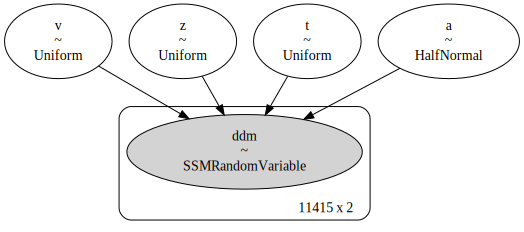

In [10]:
ddm_pymc.to_graphviz()